# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
matplotlib.use('TkAgg', warn = False)
from matplotlib import pyplot
import pickle
from pandas.io.parsers import read_csv
import random

In [2]:
# Load pickled data

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

signnames = read_csv("signnames.csv").values[:, 1]
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [11]:
n_train = y_train.shape[0]
n_test = y_test.shape[0]
image_shape = X_train[0].shape
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)
n_classes = class_counts.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples =  39209
Number of testing examples =  12630
Image data shape =  (32, 32, 3)
Number of classes =  43


### Original photos

Let's first explore data about original photos. Who knows — maybe we can spot some data correlations with signs positions in the photos or positions across specific sign classes.

Let's first plot histograms of original photos' sizes.

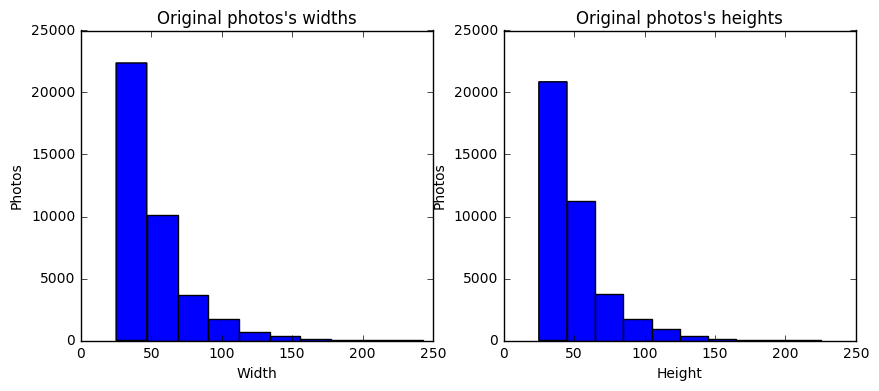

In [21]:
sizes = train["sizes"]
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]
sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(sizes[:, 0])
pyplot.title('Original photos\'s widths')
pyplot.xlabel('Width')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(sizes[:, 1])
pyplot.title('Original photos\'s heights')
pyplot.xlabel('Height')
pyplot.ylabel('Photos')

pyplot.show()

Doesn't look too promising — apparently photos are of all different sizes, majority ranging from ~30 to ~150 px both width and height. Actually both histograms looks surprisingly similar, I bet aspect ratios of all photos are close to 1. Let's check it out!

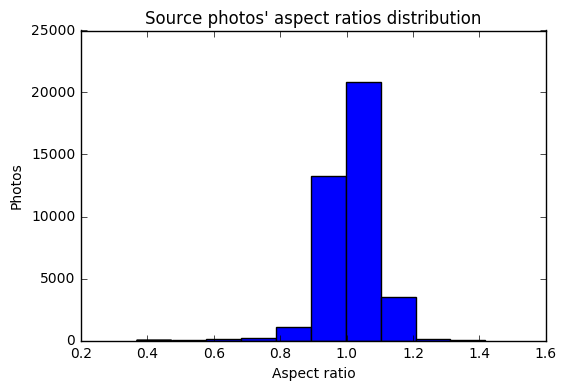

In [13]:
sizes_figure = pyplot.figure()
axis = sizes_figure.add_subplot(1, 1, 1)
axis.hist(sizes[:, 0]/sizes[:, 1])
pyplot.title('Photos\' aspect ratios distribution')
pyplot.xlabel('Aspect ratio')
pyplot.ylabel('Photos')
pyplot.show()

There you go! Vast majority of original photos had aspect ratio ranging from 0.9 to 1.2, e.g. almost all photos were more or less square.

Let's check how much area of the original image did signs occupy? In other words, to which extent did we have to crop the original photo to get the sign out of it. Again, let's check for both width and height by calculating sign dimensions as fractions of original photo dimensions.

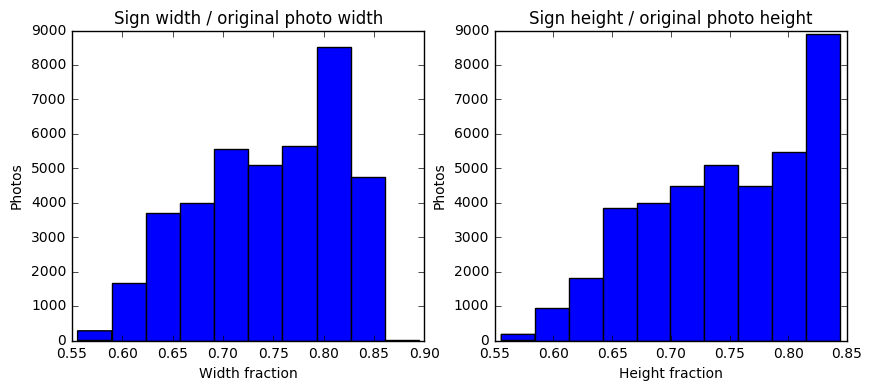

In [20]:
positions = train["coords"]
width_fraction = (positions[:, 2] - positions[:, 0]) / sizes[:, 0]
height_fraction = (positions[:, 3] - positions[:, 1]) / sizes[:, 1]
sizes_figure = pyplot.figure(figsize = (10, 4))

axis = sizes_figure.add_subplot(1, 2, 1)
axis.hist(width_fraction)
pyplot.title('Sign width / original photo width')
pyplot.xlabel('Width fraction')
pyplot.ylabel('Photos')

axis = sizes_figure.add_subplot(1, 2, 2)
axis.hist(height_fraction)
pyplot.title('Sign height / original photo height')
pyplot.xlabel('Height fraction')
pyplot.ylabel('Photos')

pyplot.show()

Not really promising either. All photos had almost nothing but signs in them, for both width and height signs occupied at least half of the dimension, and for majority of samples signs occupied around 75% of the photo.

Now, if we found any uneven distributions in the dataset I would be tempted to try and analyze it on per-class basis. Although for now data looks pretty homogeneous and I doubt there will be any meaningful patterns related to specific classes based on the original samples' images.

### Sample images

Ok, let's check out the sign samples. We will go through all dataset classes, noting number of samples and plotting 10 random images representing each class.

Speed limit (20km/h)                                210 samples


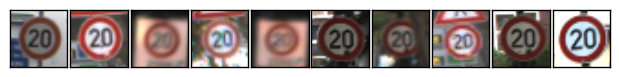

--------------------------------------------------------------------------------------

Speed limit (30km/h)                                2220 samples


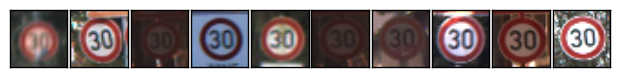

--------------------------------------------------------------------------------------

Speed limit (50km/h)                                2250 samples


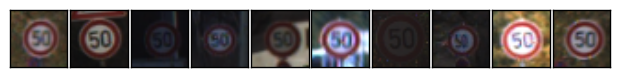

--------------------------------------------------------------------------------------

Speed limit (60km/h)                                1410 samples


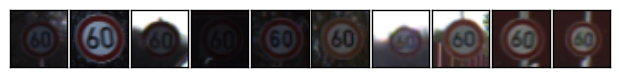

--------------------------------------------------------------------------------------

Speed limit (70km/h)                                1980 samples


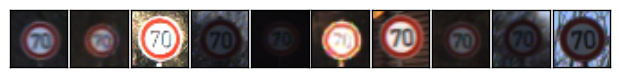

--------------------------------------------------------------------------------------

Speed limit (80km/h)                                1860 samples


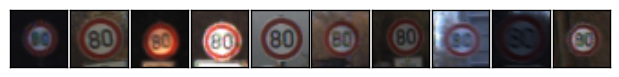

--------------------------------------------------------------------------------------

End of speed limit (80km/h)                         420 samples


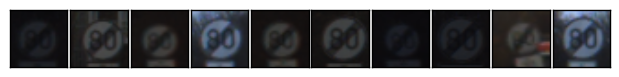

--------------------------------------------------------------------------------------

Speed limit (100km/h)                               1440 samples


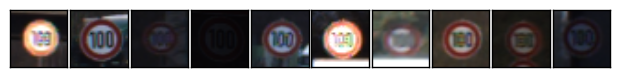

--------------------------------------------------------------------------------------

Speed limit (120km/h)                               1410 samples


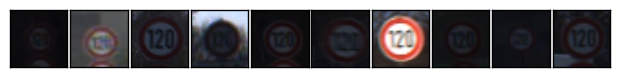

--------------------------------------------------------------------------------------

No passing                                          1470 samples


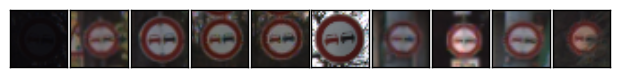

--------------------------------------------------------------------------------------

No passing for vechiles over 3.5 metric tons        2010 samples


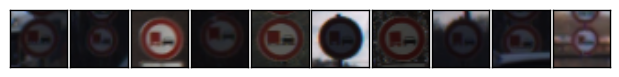

--------------------------------------------------------------------------------------

Right-of-way at the next intersection               1320 samples


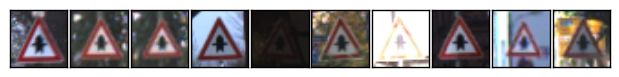

--------------------------------------------------------------------------------------

Priority road                                       2100 samples


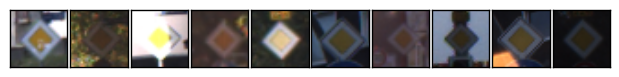

--------------------------------------------------------------------------------------

Yield                                               2160 samples


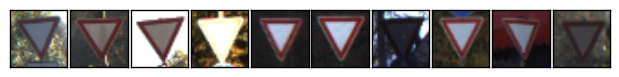

--------------------------------------------------------------------------------------

Stop                                                780 samples


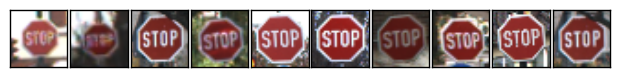

--------------------------------------------------------------------------------------

No vechiles                                         630 samples


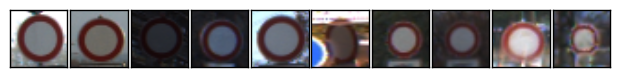

--------------------------------------------------------------------------------------

Vechiles over 3.5 metric tons prohibited            420 samples


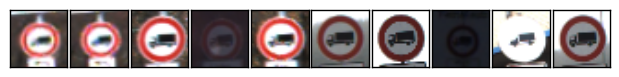

--------------------------------------------------------------------------------------

No entry                                            1110 samples


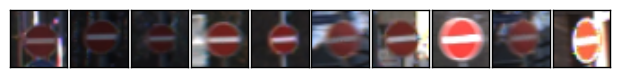

--------------------------------------------------------------------------------------

General caution                                     1200 samples


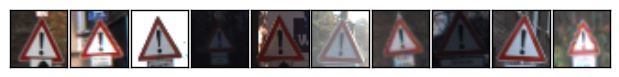

--------------------------------------------------------------------------------------

Dangerous curve to the left                         210 samples


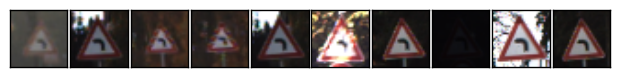

--------------------------------------------------------------------------------------

Dangerous curve to the right                        360 samples


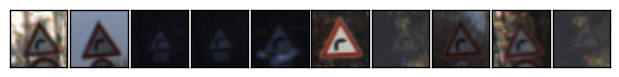

--------------------------------------------------------------------------------------

Double curve                                        330 samples


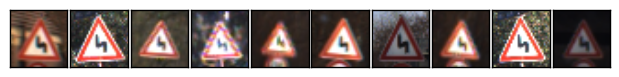

--------------------------------------------------------------------------------------

Bumpy road                                          390 samples


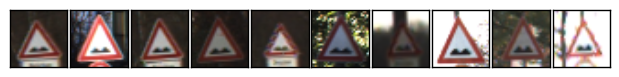

--------------------------------------------------------------------------------------

Slippery road                                       510 samples


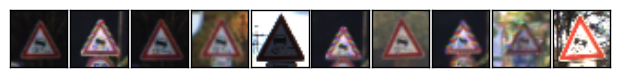

--------------------------------------------------------------------------------------

Road narrows on the right                           270 samples


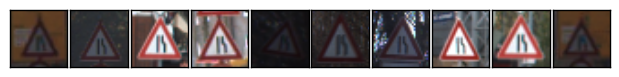

--------------------------------------------------------------------------------------

Road work                                           1500 samples


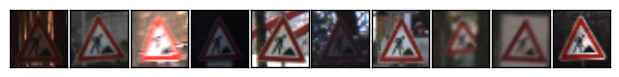

--------------------------------------------------------------------------------------

Traffic signals                                     600 samples


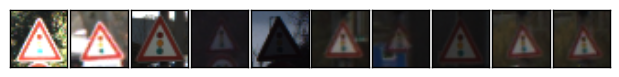

--------------------------------------------------------------------------------------

Pedestrians                                         240 samples


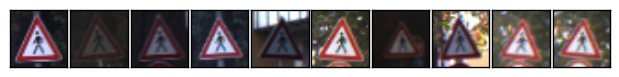

--------------------------------------------------------------------------------------

Children crossing                                   540 samples


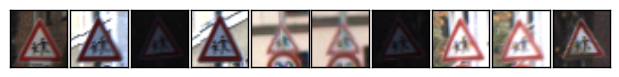

--------------------------------------------------------------------------------------

Bicycles crossing                                   270 samples


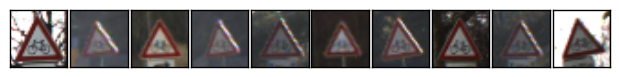

--------------------------------------------------------------------------------------

Beware of ice/snow                                  450 samples


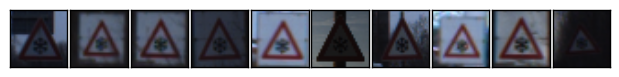

--------------------------------------------------------------------------------------

Wild animals crossing                               780 samples


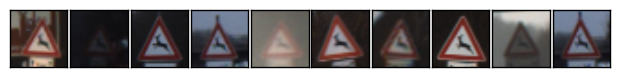

--------------------------------------------------------------------------------------

End of all speed and passing limits                 240 samples


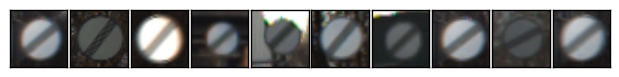

--------------------------------------------------------------------------------------

Turn right ahead                                    689 samples


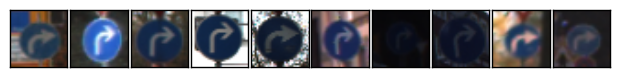

--------------------------------------------------------------------------------------

Turn left ahead                                     420 samples


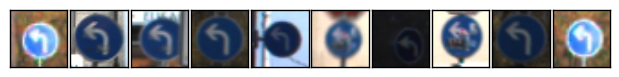

--------------------------------------------------------------------------------------

Ahead only                                          1200 samples


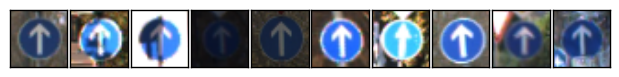

--------------------------------------------------------------------------------------

Go straight or right                                390 samples


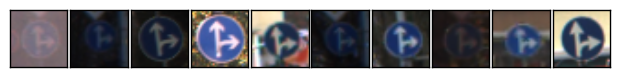

--------------------------------------------------------------------------------------

Go straight or left                                 210 samples


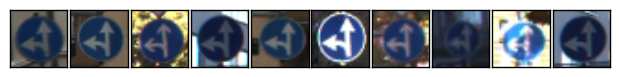

--------------------------------------------------------------------------------------

Keep right                                          2070 samples


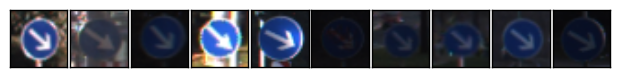

--------------------------------------------------------------------------------------

Keep left                                           300 samples


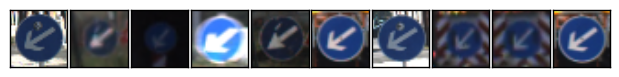

--------------------------------------------------------------------------------------

Roundabout mandatory                                360 samples


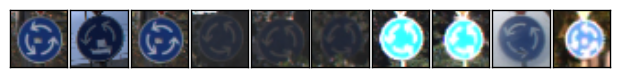

--------------------------------------------------------------------------------------

End of no passing                                   240 samples


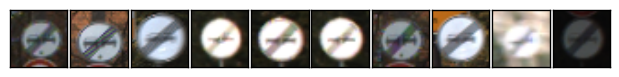

--------------------------------------------------------------------------------------

End of no passing by vechiles over 3.5 metric tons  240 samples


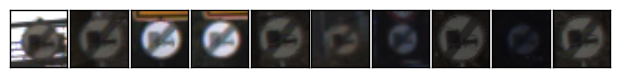

--------------------------------------------------------------------------------------



In [77]:
col_width = max(len(name) for name in signnames)

for c, c_index, c_count in zip(sign_classes, class_indices, class_counts):
    print("%-*s  %s samples" % (col_width, signnames[c], str(c_count)))
    fig = pyplot.figure(figsize = (6, 1))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    random_indices = random.sample(range(c_index, c_index + c_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.imshow(X_train[random_indices[i]])
    pyplot.show()
    print("--------------------------------------------------------------------------------------\n")

**Bad news**: Some classes are highly underrepresented. 

**Good news**: There is quite some room for data augmentation.

Images with some signs, like **Bumpy road** or **Ahead only**, can be simply flipped horizontally, thus allowing us to get twice as much data for these classes. 

Other signs come in kind of interchageable pairs, like **Keep right** and **Keep left**: those signs can be flipped and assigned to a paired class. In some cases (like **Keep right** and **Keep left**) we increase the number of samples for **Keep left** from 300 to 2370!

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [2]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.